In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

if int(os.environ.get("MODERN_PANDAS_EPUB", 0)):
    import prep # noqa

pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

In [2]:
fp = 'data/mbl.csv'
fp2 = 'data/mbl2.csv'

if not os.path.exists(fp):
    tables = pd.read_html("http://www.baseball-reference.com/teams/BOS/2016-schedule-scores.shtml#team_schedule::none")
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)

games

,Unnamed: 0,Gm#,Date,Unnamed: 2,Tm,,Opp,W/L,R,RA,...,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,Streak
0,0,1,"Tuesday, Apr 5",boxscore,BOS,@,CLE,W,6,2,...,1-0,1,Tied,Price,Kluber,NaN,3:13,D,34493,+
1,1,2,"Wednesday, Apr 6",boxscore,BOS,@,CLE,L,6,7,...,1-1,2,1.0,McAllister,Tazawa,Allen,3:29,N,10298,-
2,2,3,"Friday, Apr 8",boxscore,BOS,@,TOR,W,8,7,...,2-1,2,1.5,Barnes,Storen,Kimbrel,3:24,N,48871,+
3,3,4,"Saturday, Apr 9",boxscore,BOS,@,TOR,W,8,4,...,3-1,2,1.0,Porcello,Dickey,NaN,2:48,D,47138,++
4,4,5,"Sunday, Apr 10",boxscore,BOS,@,TOR,L,0,3,...,3-2,2,2.0,Estrada,Wright,Osuna,2:27,D,46158,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,164,160,"Friday, Sep 30",boxscore,BOS,NaN,TOR,W,5,3,...,93-67,1,up 5.0,Ziegler,Biagini,Kimbrel,3:25,N,37661,+
165,165,Gm#,October,NaN,Tm,NaN,Opp,W/L,R,RA,...,W-L,Rank,GB,Win,Loss,Save,Time,D/N,Attendance,Streak
166,166,161,"Saturday, Oct 1",boxscore,BOS,NaN,TOR,L,3,4,...,93-68,1,up 5.0,Osuna,Kimbrel,NaN,3:29,N,37396,-
167,167,162,"Sunday, Oct 2",boxscore,BOS,NaN,TOR,L,1,2,...,93-69,1,up 4.0,Sanchez,Ziegler,Osuna,3:14,D,36787,--


In [3]:
games2 = games.loc[games['Gm#'] != 'Gm#']

column_names = {'Gm#':'game-id' ,'Date': 'date','Opp' : 'oponent', 'W/L': 'w_l', 'W-L':'w-l'}

games2 = (games2.rename(columns=column_names)
    [['date', 'oponent', 'w_l']]
    .assign(date=lambda x: pd.to_datetime(x['date'], yearfirst=False, format='%A, %b %d', exact=False))
    .set_index('date', append=True)
    .rename_axis(["game_id", "date"])
    .sort_index())

games2.w_l.replace(['L-wo', 'W-wo'], ['L', 'W'], inplace=True)

games2.head()

,,oponent,w_l
game_id,date,,
0,1900-04-05,CLE,W
1,1900-04-06,CLE,L
2,1900-04-08,TOR,W
3,1900-04-09,TOR,W
4,1900-04-10,TOR,L


In [4]:
tidy = games2.reset_index()
tidy['date']=tidy['date'].apply(lambda dt: dt.replace(year=2016))
tidy.head()

,game_id,date,oponent,w_l
0,0,2016-04-05,CLE,W
1,1,2016-04-06,CLE,L
2,2,2016-04-08,TOR,W
3,3,2016-04-09,TOR,W
4,4,2016-04-10,TOR,L


In [5]:
tidy['date'].diff().dt.days-1

0      NaN
1      0.0
2      1.0
3      0.0
4      0.0
      ... 
157    0.0
158    0.0
159    0.0
160    0.0
161    0.0
Name: date, Length: 162, dtype: float64

In [6]:
tidy['rest'] = tidy.sort_values('date').date.diff().dt.days - 1
tidy.dropna()

,game_id,date,oponent,w_l,rest
1,1,2016-04-06,CLE,L,0.0
2,2,2016-04-08,TOR,W,1.0
3,3,2016-04-09,TOR,W,0.0
4,4,2016-04-10,TOR,L,0.0
5,5,2016-04-11,BAL,L,0.0
...,...,...,...,...,...
157,162,2016-09-28,NYY,L,0.0
158,163,2016-09-29,NYY,L,0.0
159,164,2016-09-30,TOR,W,0.0
160,166,2016-10-01,TOR,L,0.0


In [7]:
tidy.w_l.replace(['L', 'W'], [0, 1], inplace=True)
tidy.head()

,game_id,date,oponent,w_l,rest
0,0,2016-04-05,CLE,1,NaN
1,1,2016-04-06,CLE,0,0.0
2,2,2016-04-08,TOR,1,1.0
3,3,2016-04-09,TOR,1,0.0
4,4,2016-04-10,TOR,0,0.0


In [8]:
longest_rest = tidy.rest.max()
longest_rest

4.0

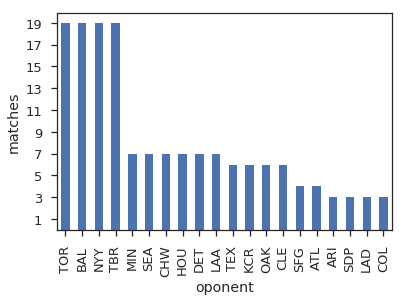

In [9]:
matches_oponents = tidy.oponent.value_counts(dropna=True)

matches_oponents.plot(kind='bar')

plt.yticks(np.arange(1,21,2))

plt.xlabel('oponent')
plt.ylabel('matches')

plt.show()

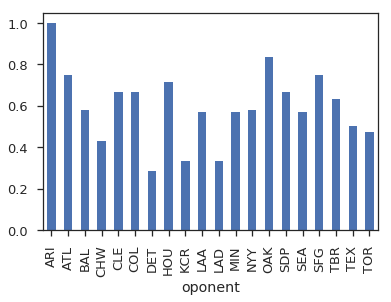

In [10]:
grouped = tidy.groupby(['oponent'])
summation = grouped.sum()

summation_sort = summation.sort_index()
matches_oponents_sort = matches_oponents.sort_index()

summation_sort.w_l = summation_sort.w_l.divide(matches_oponents_sort)

summation_sort.w_l.plot(kind='bar')

plt.show()